## Imports

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from utils.hfDataset import MHCoPilot_Dataset 
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoModelForTokenClassification,
)
from peft import (
    PeftModel,
    get_peft_model,
)
import torch
from tqdm import tqdm
# import prompts
import torch, wandb
# from mh_final.final.model import BertForMultiLabelMulticlassClassification,BertForMultiLabelMulticlassClassificationUtils
# import verifier_module_final_dpo_updated as verifier
from utils.model import RobertaForMultiLabelMulticlassClassification, RobertaForMultiLabelMulticlassClassificationUtils
import prompts

/home/bhagesh20558/miniconda3/envs/mhcp3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset Loading

Map: 100%|██████████| 476/476 [00:00<00:00, 3754.34 examples/s]


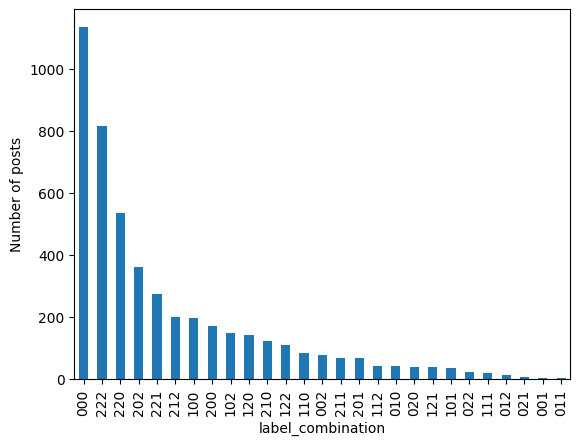

In [3]:

Dataset = MHCoPilot_Dataset("../data", task = "general", ner = True, make_new_split = False)
Dataset.get_data()

In [4]:
class spanprediction:
    def __init__(self,model,device):
        self.id2label = {
            0:'O', 1:'B-ES', 2:'I-ES', 3:'B-EFS', 4:'I-EFS', 5:'B-RS', 6:'I-RS'
        }
        self.label2id = {v:k for k,v in self.id2label.items()}
        self.device=device
        self.model=AutoModelForTokenClassification.from_pretrained(model,device_map=device,id2label=self.id2label, label2id=self.label2id)
        self.tokenizer=AutoTokenizer.from_pretrained(model)
        self.tokenizer.add_tokens(['<es>','<efs>','<rs>','<ee>', '<efe>', '<re>'])
        self.idx=0
    def id_to_label(self,outputs):
        return [self.model.config.id2label[t] for t in outputs]

    def chunking(self,example,context_size=512):

        chunks={'input_ids':[],'attention_mask':[]}
        for i in range(0, len(example['input_ids'][0]), context_size):
            chunks['input_ids'].append(example['input_ids'][0][i:i+context_size])
            chunks['attention_mask'].append(example['attention_mask'][0][i:i+context_size])
            # word_ids.append(wordids[i:i+context_size])
            if chunks['input_ids'][-1].shape[0]<context_size:
                chunks['input_ids'][-1]=torch.cat([chunks['input_ids'][-1],torch.zeros(context_size-chunks['input_ids'][-1].shape[0],dtype=torch.long)])
                chunks['attention_mask'][-1]=torch.cat([chunks['attention_mask'][-1],torch.zeros(context_size-chunks['attention_mask'][-1].shape[0],dtype=torch.long)])
        chunks['input_ids']=torch.stack(chunks['input_ids']).to(self.device)
        chunks['attention_mask']=torch.stack(chunks['attention_mask']).to(self.device)
        return chunks

    def predict(self,text):
        self.idx=0
        inputs = self.tokenizer(text, padding="max_length",return_tensors="pt",truncation=False)
        # original_inputs=self.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
        token_ids=inputs.word_ids()
        chunks=self.chunking(inputs)
        original_inputs=inputs['input_ids'][0]
        outputs = self.model(**chunks,).logits.cpu()
        if outputs.shape[0]>1:
            outputs=outputs.reshape(1,outputs.shape[1]*outputs.shape[0],outputs.shape[2])
            outputs=outputs[:,outputs.shape[1]-original_inputs.shape[0]:,:]
        # outputs=outputs.reshape(1,outputs.shape[1]*outputs.shape[0],outputs.shape[2])
        # print(outputs.shape)
        attention_mask=inputs['attention_mask'][0]
        mask = attention_mask.view(-1) == 1  # Get non-padding indices
        outputs = torch.argmax(outputs*attention_mask.unsqueeze(-1),dim=2)
        filtered_preds = torch.masked_select(outputs.view(-1), mask)
        outputs = [self.model.config.id2label[t.item()] for t in filtered_preds]
        result=self.process_otuput(original_inputs,outputs,token_ids)
        
        return result
    
    def predict_batch(self,texts):
        # inputs = self.tokenizer(texts, padding="max_length",return_tensors="pt")
        # # original_inputs=self.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
        # inputs.to(self.device)
        # outputs = self.model(**inputs).logits
        # l=[]
        # for i in range(outputs.shape[0]):
        #     temp=outputs[i].unsqueeze(0)
        #     attention_mask=inputs['attention_mask'][i].unsqueeze(0)
        #     mask = attention_mask.view(-1) == 1  # Get non-padding indices
        #     labels = torch.argmax(temp*attention_mask.unsqueeze(-1),dim=2)
        #     filtered_preds = torch.masked_select(labels.view(-1), mask)
        #     labels = [self.model.config.id2label[t.item()] for t in filtered_preds]
        #     token_ids=inputs.word_ids(batch_index=i)
        #     original_inputs=inputs['input_ids'][i]
        #     l.append(self.process_otuput(original_inputs,labels,token_ids))
        # return l
        l=[]
        for i in texts:
            l.append(self.predict(i))
        return l
    
    def process_otuput(self,inputs,preds,input_ids):
        tags={'B-ES':'<es>', 'I-ES':'<ee>', 'B-EFS':'<efs>', 'I-EFS':'<efe>', 'B-RS':'<rs>', 'I-RS':'<re>'}
        d2={}
        z=0
        for i in range(len(input_ids)):
            if input_ids[i]!=None:
                z=max(z,input_ids[i])
                if input_ids[i] not in d2:
                    d2[input_ids[i]]={"inputs":[inputs[i]],"preds":[preds[i]]}
                else:
                    d2[input_ids[i]]["inputs"].append(inputs[i])
                    d2[input_ids[i]]["preds"].append(preds[i])
        s=[]
        labels=[]
        for i in d2:
            s.append(self.tokenizer.decode(d2[i]['inputs']) )
            labels.append(d2[i]['preds'][0])

        s2=[]
        for i in range(len(s)):
            if 'B' in labels[i]:
                s2.append(tags[labels[i]])
                s2.append(s[i])
            elif i<len(s)-1 and labels[i] in tags and labels[i+1] not in tags:
                s2.append(s[i])
                s2.append(tags[labels[i]])
            else :
                s2.append(s[i])
        return "".join(s2)
        
class level_classifier:
    def __init__(self,base_name,model,device):
        self.device=device
        checkpoint = torch.load(model)
        self.model = RobertaForMultiLabelMulticlassClassification.from_pretrained(
            base_name, 
            num_labels=3,  # For 'event', 'effect', 'requirement'
            num_classes_per_label=3,  # Since each label can take values 0, 1, or 2
            device_map=device,
        )
        self.tokenizer=self.tokenizer = AutoTokenizer.from_pretrained(base_name)
        self.tokenizer.add_tokens(['<es>','<efs>','<rs>','<ee>', '<efe>', '<re>'])
        self.tokenizer.truncation_side="left"
        self.model.resize_token_embeddings(len(self.tokenizer))
        self.model.load_state_dict(checkpoint)
        
    def predict(self,text):
        inputs = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )
        inputs.to(self.device)
        outputs = self.model(**inputs)
        outputs = torch.argmax(outputs, dim=1)
        return outputs[0]
    
    def predict_batch(self,text):
        inputs = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )
        inputs.to(self.device)
        outputs = self.model(**inputs)
        outputs = torch.argmax(outputs, dim=1)
        return outputs
    
class generator:
    def load_model(self,base_model,model_name,model_type):
        tokenizer=AutoTokenizer.from_pretrained(model_name)
        tokenizer.truncation_side="left"
        tokenizer.padding_side="left"
        model = AutoModelForCausalLM.from_pretrained(
        base_model,
        load_in_8bit=True,
        torch_dtype = torch.bfloat16,
        attn_implementation=self.attn_implementation,
        device_map=self.device
        )
        if model_type=="dpo":
            peft_model = PeftModel.from_pretrained(model, model_name+"/train1")
        elif model_type=="sft":
            peft_model = PeftModel.from_pretrained(model, model_name)
        peft_model.config.use_cache = True
        return peft_model,tokenizer
    
    def __init__(self,base_model,model,device,model_type):
        self.device=device
        self.attn_implementation="flash_attention_2"
        self.model,self.tokenizer=self.load_model(base_model,model,model_type)
        self.generation_kwargs={"num_return_sequences":1,"max_new_tokens":100}
        self.context_length=1024
        self.prompt_template=prompts.gemma_get_prompt
        self.system_prompt='''A support seeker on a peer-to-peer (P2P) Online Mental Health Platform (OMHP) is an individual who utilizes digital services to seek assistance/help for managing and improving their mental health, typically through interactions with peer groups or self-help resources.
        The parameters are defined as follows:
            Event: This parameter encapsulates the specific situation, activity, or event that is the focal point of the support seeker’s concern. The explicit detailing of such events provides a contextual background essential for empathetic understanding.
            Effect: This aspect targets the impact or consequences of the identified event on the support seeker. By elucidating the effect, the post conveys the emotional or practical repercussions of the event, thereby inviting more targeted and empathetic responses. 
            Requirement: This parameter is critical in directing the nature of the assistance sought. It ranges from emotional and informational support to instrumental aid, thereby guiding the potential response trajectory.

        In the posts on OMHP these parameters can have intensity ranging from 0 to 2, where 0 means absent, 1 means present but needs clarification and 2 being well described based on the presence of these parameters in the post

            Consider the following post by a support seeker on a OMHP, in which the spans of text representing Event, Effect and Requirement have been marked. Also, the intensity levels for each of the parameters in the post have been provided along with the post.
            The post is context of the victim.
            The post <es> and <ee> tags encapsulate the spans for the Event parameter, <efs> and <efe> tags encapsulate the spans for the Effect parameter, and <rs> and <re> tags encapsulate the spans for the Requirement parameter.
        '''
    def prepare_eval(self,annotated_post_body,levels):
        post=annotated_post_body
        note="Generate 3 questions following the schema according to the scale of event, effect and requirement provided below the post, for helping the support giver to understand more about the victim.Strictly follow the question format of schema.Give only the json output as specified in the schema and no explanation needed."
        prompt="Post: "+post+"\n\n"+"event scale: "+str(levels[0].item())+" effect scale: "+str(levels[1].item())+" requirement scale: "+str(levels[2].item())+"\n\n"+"schema:\n"+'''{"event_question": "","effect_question": "","requirement_question": ""}'''+"\n\n"+note
        # print(prompt)
        model_input=self.prompt_template(self.system_prompt,prompt)
        return model_input

    def generate(self,annotated_post_body,levels):
        print(levels)

        text=[self.prepare_eval(annotated_post_body[i],levels[i].detach().cpu()) for i in range(len(annotated_post_body))]
        inputs = self.tokenizer(text, return_tensors='pt',padding=True, 
                            max_length=self.context_length,truncation=True).to("cuda:0")
        preds=[]
        inputs.to(self.device)
        outputs = self.model.generate(**inputs,**self.generation_kwargs)
        text = self.tokenizer.batch_decode(outputs[:,inputs['input_ids'].shape[1]:], skip_special_tokens=True)
        for i in text:
            preds.append(i)
        return preds

In [5]:
test_data=Dataset.test_df
print(test_data[1])
test_data=test_data.remove_columns(['title', 'annotated_post_body', 'EMaskingQ', 'EMask', 'EFSMaskingQ', 'EFSMask', 'RMaskingQ', 'RMask', 'labels', 'ner_tokens', 'ner_labels'])

{'title': 'Burnt out in my current career and unsure of where to go next', 'body': 'I (F, 25, ADHD combination type) have been with my current company for about a year and a half. It started out great!\n\nThings I enjoyed initially:\n\n• Flexible boss\n\n• Engaging projects\n\n• Good individual &amp; teamwork balance \n\n• The fact that I was working in a field that somewhat aligned with my college education\n\nAbout 5 months in, things changed and it has been quite the trainwreck:\n\n•Lost motivation/interest for even the simplest tasks &amp; projects\n\n•Made some pretty significant mistakes due to poor planning/time management and lack of attention to detail\n\n•Work-life balance is shot due to 50-80 hour work weeks including weekends during the fall, winter and early spring- my personal life is really important to me and it has taken a huge hit as a result\n\n• Coworkers treat me like I’m incompetent &amp; constantly talk about me within earshot (no help from our boss) \n\nI’ve tri

In [6]:
span_model="../spanpred/results_roberta-testing"
span_predictor=spanprediction(span_model,"cuda:0")

In [8]:
level_model=level_classifier("roberta-base","checkpoints/clf_RoBERTa-ordinal.pt","cuda:0")


Some weights of RobertaForMultiLabelMulticlassClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
gen_dpo_model=generator("google/gemma-2b-it","../Pipeline/gemma2-dpo-2final","cuda:0","dpo")

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


In [ ]:
import json
def prepare(row):
    return row
from torch.utils.data import DataLoader
test_data=test_data.map(prepare,batched=False).select(range(100))
dataloader = DataLoader(test_data, batch_size=6,shuffle=False)
d={'post':[],"spans":[],"levels":[]}
l=[]
d['dpo_questions']=[]
t=0
for batch in tqdm(dataloader,total=len(dataloader)):
    span_output=l[t][0]
    level_output=l[t][1]
    gen_output=gen_dpo_model.generate(span_output,level_output)
    # d['post'].extend(batch['body']
    t+=1
    d['dpo_questions'].extend([json.loads(output.strip()) for output in gen_output])

  0%|          | 0/17 [00:00<?, ?it/s]

tensor([[2, 1, 1],
        [2, 2, 1],
        [2, 1, 0],
        [2, 0, 1],
        [1, 1, 0],
        [1, 1, 1]])


  6%|▌         | 1/17 [00:09<02:34,  9.68s/it]

tensor([[2, 0, 0],
        [1, 1, 2],
        [1, 1, 2],
        [1, 2, 0],
        [1, 1, 1],
        [2, 1, 1]])


 12%|█▏        | 2/17 [00:18<02:15,  9.04s/it]

tensor([[2, 1, 1],
        [1, 0, 2],
        [1, 1, 0],
        [1, 0, 2],
        [2, 0, 0],
        [0, 1, 2]])


 18%|█▊        | 3/17 [00:27<02:05,  8.99s/it]

tensor([[2, 0, 0],
        [2, 1, 1],
        [1, 1, 2],
        [2, 1, 1],
        [1, 1, 0],
        [2, 2, 1]])


 24%|██▎       | 4/17 [00:34<01:50,  8.49s/it]

tensor([[1, 0, 2],
        [2, 1, 1],
        [2, 1, 1],
        [1, 0, 0],
        [2, 1, 0],
        [2, 0, 1]])


 29%|██▉       | 5/17 [00:43<01:41,  8.47s/it]

tensor([[2, 2, 1],
        [1, 1, 1],
        [2, 2, 0],
        [1, 2, 1],
        [2, 1, 1],
        [1, 0, 2]])


 35%|███▌      | 6/17 [00:52<01:34,  8.62s/it]

tensor([[1, 2, 1],
        [2, 1, 0],
        [2, 2, 0],
        [1, 1, 1],
        [1, 0, 2],
        [2, 1, 0]])


 41%|████      | 7/17 [01:00<01:26,  8.61s/it]

tensor([[1, 1, 2],
        [1, 0, 2],
        [2, 1, 0],
        [2, 0, 1],
        [1, 2, 2],
        [1, 2, 0]])


 47%|████▋     | 8/17 [01:09<01:17,  8.61s/it]

tensor([[1, 1, 1],
        [2, 1, 1],
        [2, 0, 0],
        [1, 0, 2],
        [2, 2, 1],
        [1, 1, 0]])


 53%|█████▎    | 9/17 [01:18<01:09,  8.67s/it]

tensor([[1, 1, 1],
        [1, 0, 2],
        [2, 2, 1],
        [1, 1, 1],
        [0, 1, 2],
        [0, 1, 2]])


 59%|█████▉    | 10/17 [01:27<01:00,  8.70s/it]

tensor([[1, 2, 1],
        [2, 1, 1],
        [1, 1, 1],
        [1, 0, 2],
        [2, 0, 1],
        [2, 1, 1]])


 65%|██████▍   | 11/17 [01:35<00:52,  8.77s/it]

tensor([[1, 2, 2],
        [2, 1, 1],
        [1, 0, 2],
        [2, 1, 1],
        [0, 2, 1],
        [2, 1, 1]])


 71%|███████   | 12/17 [01:43<00:42,  8.41s/it]

tensor([[1, 2, 2],
        [2, 1, 0],
        [2, 1, 2],
        [2, 1, 1],
        [1, 1, 0],
        [2, 1, 1]])


 76%|███████▋  | 13/17 [01:52<00:34,  8.53s/it]

tensor([[2, 1, 1],
        [2, 0, 0],
        [1, 0, 0],
        [1, 1, 2],
        [1, 1, 0],
        [1, 1, 2]])


 82%|████████▏ | 14/17 [02:01<00:25,  8.63s/it]

tensor([[1, 1, 2],
        [1, 0, 2],
        [2, 0, 1],
        [2, 1, 2],
        [1, 1, 2],
        [1, 0, 2]])


 88%|████████▊ | 15/17 [02:08<00:16,  8.16s/it]

tensor([[2, 1, 1],
        [1, 1, 2],
        [1, 1, 1],
        [1, 1, 2],
        [1, 0, 2],
        [0, 1, 2]])


 94%|█████████▍| 16/17 [02:15<00:08,  8.00s/it]

tensor([[2, 1, 1],
        [1, 1, 2],
        [1, 1, 1],
        [1, 2, 0]])


100%|██████████| 17/17 [02:24<00:00,  8.50s/it]
